# TAS Analysis
___

##### Dependencies

In [21]:
import os
from boo import Perceptron

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, make_classification, load_breast_cancer
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD, FactorAnalysis
from sklearn.linear_model import ( LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                   BayesianRidge, SGDRegressor, SGDClassifier,
                                   Lasso, ElasticNet, BayesianRidge, HuberRegressor )
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.svm import SVR, SVC, OneClassSVM
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor,
                              GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor,
                              HistGradientBoostingClassifier, HistGradientBoostingRegressor, IsolationForest )
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score,
    precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from openai import OpenAI
import seaborn as sns
from booger import Error, ErrorDialog
import warnings
from importlib import reload

In [2]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

##### Data

### 📊 Exploratory Analysis


In [ ]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\source\repos\Boo\data\excel\Account Balances.xlsx'
df_original = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
numeric_subset = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Copy original data as loaded
df_balances = df_original.copy( )

# Filter values
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'MainAccountCode', 'TreasuryAccountSymbol'  ] + numeric_subset
dropcols = [ 'AccountBalancesId', 'FederalAccountSymbol', 'FederalAccountName', 'SubAccountCode',
             'LastModified', 'SubmissionPeriod', 'BudgetFunction', 'LastModified', 'SubmissionPeriod' ]

df_balances.drop( columns=dropcols, inplace=True, errors='ignore' )
df_balances.fillna(0, inplace=True)

# Define complete dataset
df_dataset = df_balances.copy( )

# Define working subsets
df_subset = df_dataset[ subset ].copy( )
df_numeric = df_dataset[ numeric_columns ].copy( )

print( hdr )
print( 'Original Data' )
print( nwln )

df_dataset

In [ ]:
print( hdr )
print( 'Numeric' )
print( nwln )

df_numeric = df_balances[ numeric_columns ].copy( )
df_numeric

In [ ]:
print( hdr )
print( 'Subset' )
print( nwln )

df_subset

### 📊 Descriptive Statistics

In [ ]:
print( hdr )
print( 'Descriptive Statistics - Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_dataset[ numeric_columns ].describe( percentiles=[ .10, .25, .5, .75, .95 ] )
df_descriptive.round( 2 )


#### 🔍 Correlation Matrix

In [ ]:
print( hdr )
print( 'Correllation Matrix' )
print( nwln )

# Compute correlation matrix
correlation_matrix = df_dataset.corr( numeric_only=True )
correlation_matrix.round( 2 )

#### ⚙️ t-Test
- Between high and low execution groups

In [ ]:
# Perform t-tests between high and low execution groups
df_dataset[ 'ExecutionRate' ] = df_dataset[ 'Obligations' ] / df_dataset[ 'TotalResources' ]
df_dataset = df_dataset.replace( [ np.inf, -np.inf ], np.nan ).dropna( subset=[ 'ExecutionRate' ] )
threshold = df_dataset[ 'ExecutionRate' ].median( )
df_dataset[ 'HighExecution' ] = (df_dataset[ 'ExecutionRate' ] > threshold).astype( int )

# Update variables get_list based on correct column names
variables = numeric_columns

# Re-run the t-test loop
ttest_results = []

for var in variables:
    group0 = df_dataset[ df_dataset[ 'HighExecution' ] == 0 ][var ]
    group1 = df_dataset[ df_dataset[ 'HighExecution' ] == 1 ][var ]
    t_stat, p_val = stats.ttest_ind( group0, group1, equal_var=False )
    ttest_results.append({
        'Variable': var,
        'High-Execution': group0.mean( ).round( 2 ),
        'Low-Execution': group1.mean( ).round( 2 ),
        't-Statistic': t_stat.round( 2 ),
        'p-Value': p_val
    })

df_ttest = pd.DataFrame( ttest_results )

print( hdr )
print( 't-Test Results' )
print( nwln )

df_ttest

#### 📋 Confidence Intervals
- 95% confidence level

In [ ]:
# Confidence Intervals (95% confidence level)
confidence_level = 0.95
means = df_numeric.mean( )
std_errors = df_numeric.std( ) / np.sqrt( len( df_numeric ) )
confidence_intervals = {
    col: stats.t.interval( confidence_level, len( df_numeric[ col ] ) - 1, loc=means[ col ], scale=std_errors[ col ] )
    for col in df_numeric.columns
}


print( hdr )
print( 'Confidence Intervals (95% confidence level)' )
print( nwln )

confidence_intervals
df_confidence = pd.DataFrame( confidence_intervals, index=[ 'Lower', 'Upper' ] )
df_confidence.round( 2 )


#### 📊 Hypothesis Testing
- Testing if the mean is significantly different from zero

In [ ]:
# Hypothesis Testing (Testing if the mean is significantly different from zero)
hypothesis_results = {
    column: stats.ttest_1samp( df_numeric[ column ], 0 ) for column in df_numeric.columns
}

print( hdr )
print( 'Hypothesis Test ' )
print( nwln )

df_hypothesis = pd.DataFrame( hypothesis_results, index=[ 't-Test Statistic', 'p-Value' ] )
df_hypothesis.round( 2 )


#### 📉 Shapiro-Wilk Testing

In [ ]:
print( hdr )
print( 'Normality Testing using the Shapiro-Wilk test ' )
print( nwln )

# Normality Testing using the Shapiro-Wilk test
normality_results = { col: stats.shapiro(df_numeric[col ].sample(500, random_state=1 ) ) for col in df_numeric.columns if len(df_numeric) > 500 }
df_normality = pd.DataFrame( normality_results, index=[ 'Shaprio-Wilk Statistic', 'p-Value' ] )
df_normality.round(2)


### Dimensionality Reduction & Anomaly Detection

#### ✨ Feature Standardiztion

In [81]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = ( target > target.median( ) ).astype( int )

# Standardize features
scaler = StandardScaler()
data = scaler.fit_transform( values )

#### 🧮 Principle Component Analysis

In [ ]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = {
    "PCA": PCA(n_components=2)
}

reduced_data = {}

for name, reducer in reduction_methods.items():
    try:
        X_red = reducer.fit_transform( data )
        reduced_data[name] = X_red

        # Plot each result
        plt.figure(figsize=(10, 6))
        plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.5)
        plt.title(f'{name}')
        plt.xlabel('Component-1')
        plt.ylabel('Component-2')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{name} failed: {e}")

#### 🔸 Incremental PCA

In [ ]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = {
    "Incremental PCA": IncrementalPCA(n_components=2, batch_size=200),
}

reduced_data = {}

for name, reducer in reduction_methods.items():
    try:
        X_red = reducer.fit_transform( data )
        reduced_data[name] = X_red

        # Plot each result
        plt.figure(figsize=(10, 6))
        plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.5)
        plt.title(f'{name}')
        plt.xlabel('Component-1')
        plt.ylabel('Component-2')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{name} failed: {e}")

#### ⚙️ Truncated SVD


------------------------------------------------------------------------------------------------------------------------

Dimensionality-Reduction 




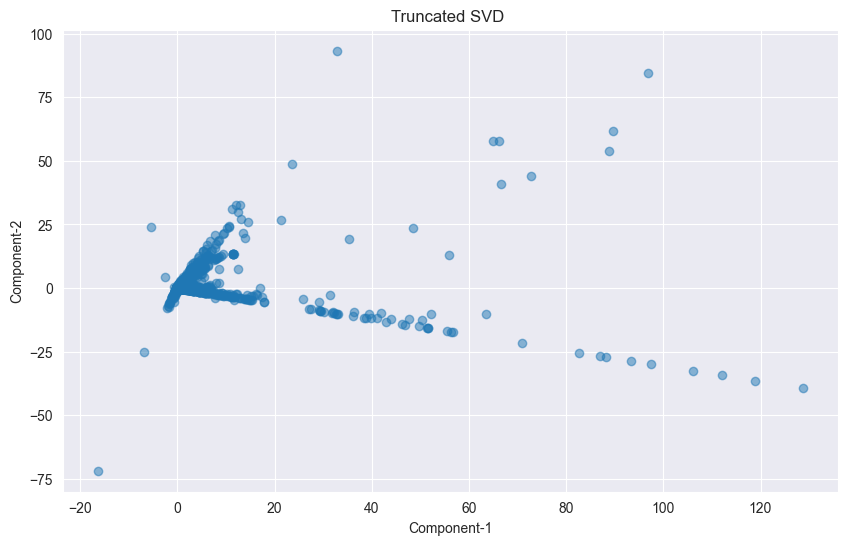

In [84]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = {
    "Truncated SVD": TruncatedSVD(n_components=2),
}

reduced_data = {}

for name, reducer in reduction_methods.items():
    try:
        X_red = reducer.fit_transform( data )
        reduced_data[name] = X_red

        # Plot each result
        plt.figure(figsize=(10, 6))
        plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.5)
        plt.title(f'{name} ')
        plt.xlabel('Component-1')
        plt.ylabel('Component-2')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{name} failed: {e}")

#### ✨ Factor Analysis


------------------------------------------------------------------------------------------------------------------------

Dimensionality-Reduction 




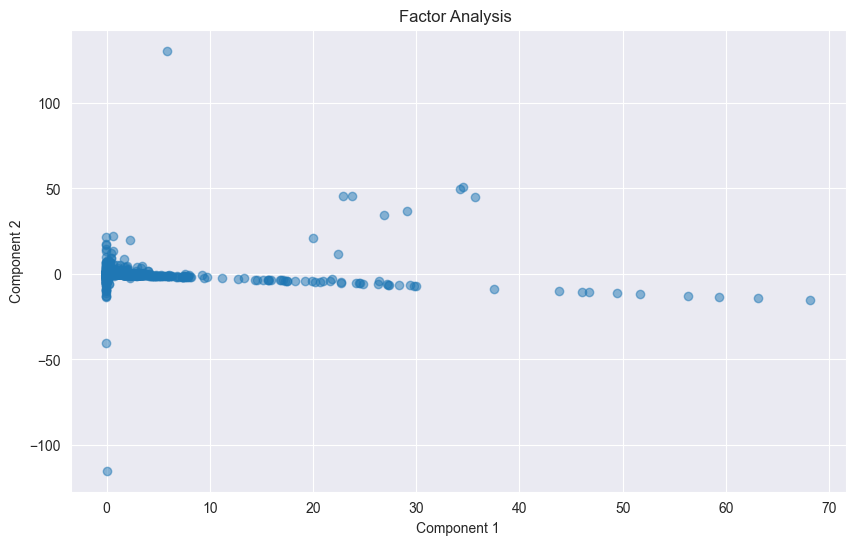

In [78]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = {
    "Factor Analysis": FactorAnalysis(n_components=2)
}

reduced_data = {}

for name, reducer in reduction_methods.items():
    try:
        X_red = reducer.fit_transform( data )
        reduced_data[name] = X_red

        # Plot each result
        plt.figure(figsize=(10, 6))
        plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.5)
        plt.title(f'{name}  ')
        plt.xlabel('Component-1')
        plt.ylabel('Component-2')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{name} failed: {e}")

### 🔂 TNSE

In [17]:

reduction_methods = {
    "TSNE": TSNE(n_components=2, perplexity=30, random_state=42)
}

reduced_data = {}

for name, reducer in reduction_methods.items():
    try:
        X_red = reducer.fit_transform( data )
        reduced_data[name] = X_red

        # Plot each result
        plt.figure(figsize=(10, 6))
        plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.5)
        plt.title(f'{name}')
        plt.xlabel('Component-1')
        plt.ylabel('Component-2')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{name} failed: {e}")

KeyboardInterrupt: 

#### 📈 Isloation Forest

In [77]:
print( hdr )

anomaly_models = {
    "IsolationForest": IsolationForest(contamination=0.05, random_state=42)
}

anomaly_results = {}
for name, model in anomaly_models.items():
    try:
        model.fit(data)
        preds = model.predict(data)  # -1 = outlier, 1 = inlier
        anomaly_results[name] = {
            "Outliers": int((preds == -1).sum()),
            "Inliers": int((preds == 1).sum()),
            "Sample Labels": preds[:10].tolist()
        }
    except Exception as e:
        anomaly_results[name] = {"Error": str(e)}

outliers = int((preds == -1).sum() )
inliers = int((preds == 1).sum() )
labels = preds[:10].tolist()


print( 'Isolation-Forest - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}')
print( f'Inliers - {inliers}')
print( f'Labels - {len(labels)}')




------------------------------------------------------------------------------------------------------------------------

Isolation-Forest - Anomaly Detection:
----------------
Outliers - 2850
Inliers - 54137
Labels - 10


#### 📋 One-Class, Support Vector Machine

In [73]:
print( hdr )

#  Define anomaly detection models
anomaly_models = {
    "OneClassSVM": OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
}

anomaly_results = {}
for name, model in anomaly_models.items():
    try:
        model.fit(data)
        preds = model.predict(data)  # -1 = outlier, 1 = inlier
        anomaly_results[name] = {
            "Outliers": int((preds == -1).sum()),
            "Inliers": int((preds == 1).sum()),
            "Sample Labels": preds[:10].tolist()
        }
    except Exception as e:
        anomaly_results[name] = {"Error": str(e)}

outliers = int((preds == -1).sum() )
inliers = int((preds == 1).sum() )
labels = preds[:10].tolist()

print( 'One-Class, Support Vector Machine - Anomaly Detection:' )
print( '-------------' )
print( f'Outliers - {outliers}')
print( f'Inliers - {inliers}')
print( f'Labels - {len(labels)}')


------------------------------------------------------------------------------------------------------------------------

One Class, Support Vector Machine Anomaly Detection:
-------------
Outliers - 2849
Inliers - 54138
Labels - 10


#### 🎯 Local Outlier Factor

In [74]:
print( hdr )

# 3. Define anomaly detection models
anomaly_models = {
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
}

anomaly_results = {}
for name, model in anomaly_models.items():
    try:
        model.fit(data)
        preds = model.predict(data)  # -1 = outlier, 1 = inlier
        anomaly_results[name] = {
            "Outliers": int((preds == -1).sum()),
            "Inliers": int((preds == 1).sum()),
            "Sample Labels": preds[:10].tolist()
        }
    except Exception as e:
        anomaly_results[name] = {"Error": str(e)}

outliers = int((preds == -1).sum() )
inliers = int((preds == 1).sum() )
labels = preds[:10].tolist()

print( 'Local Outlier Factor - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}')
print( f'Inliers - {inliers}')
print( f'Labels - {len(labels)}')


------------------------------------------------------------------------------------------------------------------------

Local Outlier Factor Anomaly Detection:
----------------
Outliers - 2516
Inliers - 54471
Labels - 10


#### ✨ Elliptic Envelope

In [75]:
print( hdr )

# 3. Define anomaly detection models
anomaly_models = {
    "EllipticEnvelope": EllipticEnvelope(contamination=0.05, random_state=42)
}

anomaly_results = {}
for name, model in anomaly_models.items():
    try:
        model.fit(data)
        preds = model.predict(data)  # -1 = outlier, 1 = inlier
        anomaly_results[name] = {
            "Outliers": int((preds == -1).sum()),
            "Inliers": int((preds == 1).sum()),
            "Sample Labels": preds[:10].tolist()
        }
    except Exception as e:
        anomaly_results[name] = {"Error": str(e)}

outliers = int((preds == -1).sum() )
inliers = int((preds == 1).sum() )
labels = preds[:10].tolist()

print( 'Elliptic Envelope - Anomaly Detection:' )
print( '----------------' )
print( f'Outliers - {outliers}')
print( f'Inliers - {inliers}')
print( f'Labels - {len(labels)}')


------------------------------------------------------------------------------------------------------------------------

Elliptic Envelope Anomaly Detection:
----------------
Outliers - 2850
Inliers - 54137
Labels - 10


### 🔢 K-Nearest Neighbors Classifier:
- This heatmap shows classification performance, identifying whether a value is above or below the median.
- Each prediction is based on a majority vote from the 5 nearest neighbors.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 95.6%
Testing  Score:  93.4%




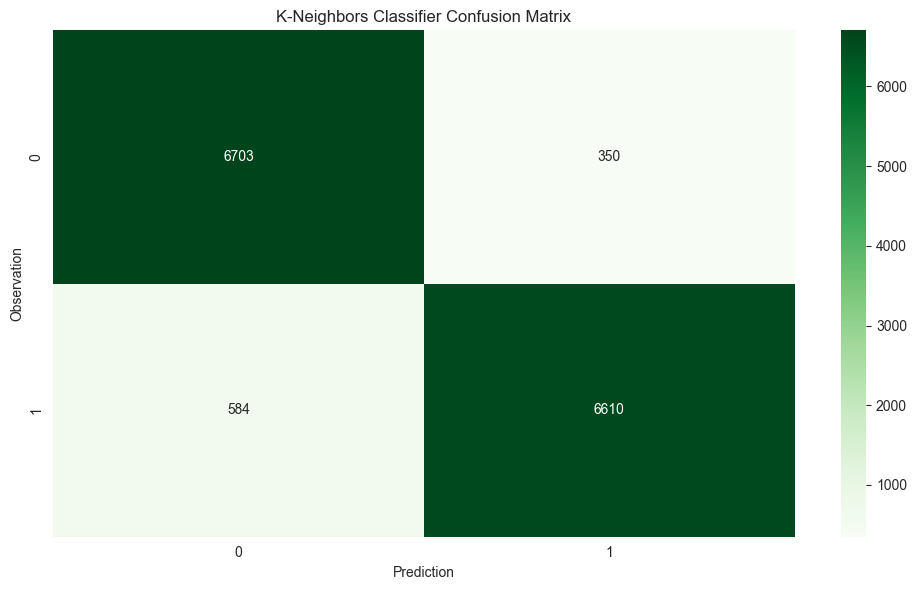

In [87]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype(int )

# Standardize features
scaler = StandardScaler()
data = scaler.fit_transform( values )

# Split values
X_train, X_test, y_train, y_test = train_test_split( data, classifier, random_state=42 )

# Fit & Predict
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train )
y_pred_knn_clf = knn_clf.predict(X_test )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {knn_clf.score( X_train, y_train ):.1%}'
testing_score = f'Testing  Score:  {knn_clf.score( X_test, y_test ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# Plot KNN Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test, y_pred_knn_clf ), annot=True, fmt='d', cmap='Greens' )
plt.xlabel('Projection')
plt.ylabel('Observation')
plt.title('K-Neighbors Classifier Confusion Matrix')
plt.tight_layout()
plt.show()

### 📊 K-Neighbors Regression:
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 75.3%
Testing  Score:  93.8%




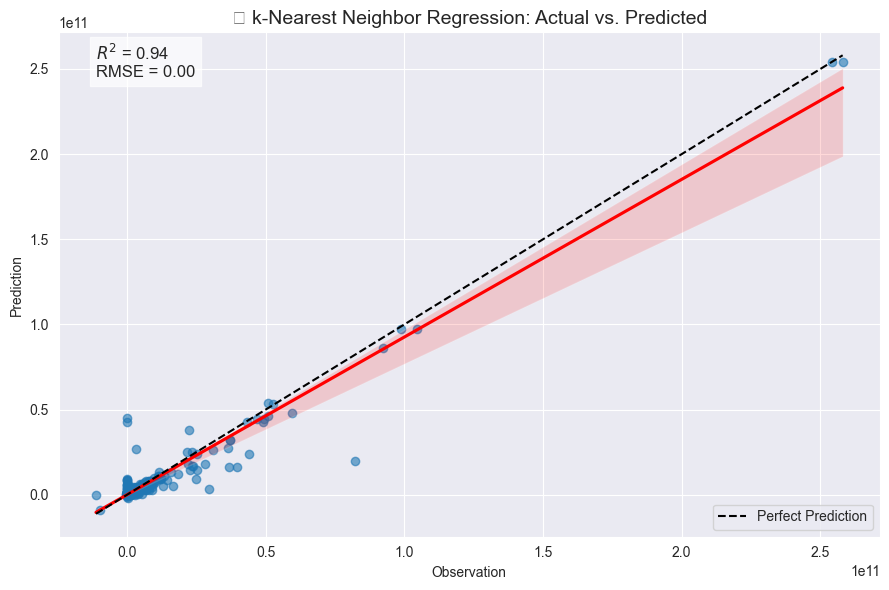

In [86]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError('Not enough numeric columns for modeling.')

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype(int )

# Standardize features
scaler = StandardScaler()
data = scaler.fit_transform( values )

# Split values
X_train, X_testing, y_train, y_testing = train_test_split( data, target, random_state=42 )

# Train, fit & predict
knn_reg = KNeighborsRegressor( n_neighbors=5 )
knn_reg.fit( X_train, y_train )
y_pred_knn_reg = knn_reg.predict( X_testing )

# Score Model
training_score = f'Training Score: {knn_reg.score( X_train, y_train ):.1%}'
testing_score = f'Testing  Score:  {knn_reg.score( X_testing, y_testing ):.1%}'
print( hdr )
print( 'Model Performance' )
print( nwln )
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_knn_reg )
rmse = mean_squared_error( y_testing, y_pred_knn_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize=( 9, 6 ) )
sns.regplot( x=y_testing, y=y_pred_knn_reg, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'} )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--', label='Perfect Prediction' )
plt.text( x=y_testing.min( ), y=y_testing.max( ) * 0.95,
         s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('🌳 k-Nearest Neighbor Regression: Actual vs. Predicted', fontsize=14)
plt.legend( )
plt.grid(True)
plt.tight_layout( )
plt.show( )